# Advanced Classification- Predict

## Introduction

In [1]:
# comet
from comet_ml import Experiment

In [2]:
#experiment = Experiment(api_key= 'nMFyxVc83DoLqA49L7VFRRs6w', project_name = 'Classification_AE1')

In [5]:
pip install emoji

Note: you may need to restart the kernel to use updated packages.


In [85]:
import nltk

import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier


# Accuracy Scores
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn import metrics

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Data Cleaning
import emoji
from bs4 import BeautifulSoup
import re
import itertools

# For precision, recall, etc.
from sklearn.metrics import classification_report

In [147]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
tweetid = test['tweetid']

In [143]:
train_df = train.copy()

In [67]:
train_df.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


In [8]:
train_df['message'].iloc[2]

'RT @RawStory: Researchers say we have three years to act on climate change before it’s too late https://t.co/WdT0KdUr2f https://t.co/Z0ANPT…'

Reorder columns so that our predicted variable is the last column of the dataframe

In [9]:
column_titles = [col for col in train_df.columns if col!= 'sentiment'] + ['sentiment']
train_df = train_df.reindex(columns=column_titles)

X = train_df.iloc[:, :-1]

y = train_df.iloc[:, -1]

We'll print off a list of all the sentiment analysis polarity in this dataset:

In [10]:
sentiments_list = list(train_df.sentiment.unique())
print(sentiments_list)

[1, 2, 0, -1]


In [11]:
working_df = train.copy()
# Labeling the target
working_df['sentiment'] = [['Negative', 'Neutral', 'Positive', 'News'][x+1] for x in working_df['sentiment']]

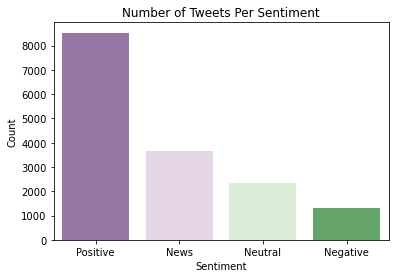

In [12]:
sns.countplot(x='sentiment' ,data = working_df, palette='PRGn')
plt.ylabel('Count')
plt.xlabel('Sentiment')
plt.title('Number of Tweets Per Sentiment')

plt.show()

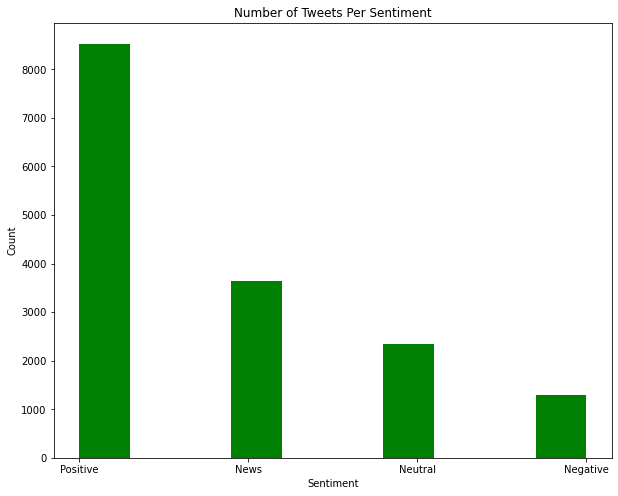

In [13]:
fig = plt.figure(figsize=(10,8))
plt.hist(working_df['sentiment'], label='data', color=["g"])
plt.xlabel('Sentiment')
plt.title('Number of Tweets Per Sentiment')

plt.ylabel('Count')
plt.show()

**There is imbalanced data

In [14]:
train_df[train_df['sentiment']==2].head()

,message,tweetid,sentiment
2,RT @RawStory: Researchers say we have three ye...,698562,2
12,RT @tveitdal: We only have a 5 percent chance ...,454673,2
14,Fossil fuel giant ExxonMobil ‘misled’ the publ...,658092,2
26,Bangladesh confronting climate change head on ...,365291,2
32,RT @latimes: Atmospheric rivers fueled by clim...,143471,2


In [15]:
from nltk.tokenize import TreebankWordTokenizer
#Try Tweet tokenizer
tokeniser = TreebankWordTokenizer()
train_df['tokens'] = train_df['message'].apply(tokeniser.tokenize)

# Defining the features as well as the label
X = train_df['tokens']

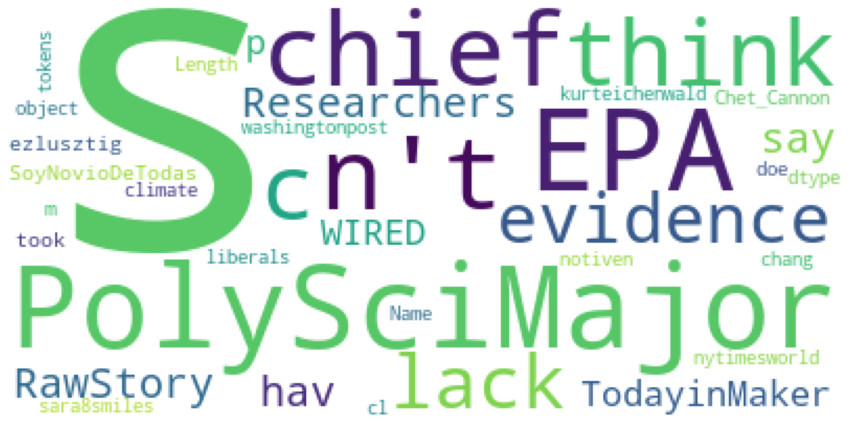

<Figure size 432x288 with 0 Axes>

In [16]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

my_stopwords = set(STOPWORDS)
my_stopwords.update(["rt", "doesnt", "hey", "hi"])

#% matplotlib inline
wordcloud = WordCloud(background_color='white',stopwords=my_stopwords,max_words=100,max_font_size=1500, random_state=42).generate(str(X))
#print(wordcloud)

fig = plt.figure(figsize=(15,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
plt.savefig('wordcloud.png', dpi=300, bbox_inches='tight')

In [17]:
plt.savefig('wordcloud.png', dpi=300, bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

## Text Cleaning

### Removing Noise

When performing text analytics, removing noise (i.e. unneccesary information) is instrumental in getting the data into a usable format.

For the Tweeter dataset we will be doing the following steps:

- removing url
- making everything lower case
- removing punctuation



Using regular expressions we can effectively removes all websites and replaces them with the text `'web-url'` 

In [2]:
import string

In [49]:
def strip_accents(text):
    if 'ø' in text or  'Ø' in text:
        #Do nothing when finding ø 
        return text   
    text = text.encode('ascii', 'ignore')
    text = text.decode("utf-8")
    return str(text)


def tweet_cleaning_for_sentiment_analysis(tweet):    
    
    #Escaping HTML characters
    tweet = BeautifulSoup(tweet).get_text()
    #Special case not handled previously.
    tweet = tweet.replace('\x92',"'")
    #Removal of hastags/account
    tweet = ' '.join(re.sub("(@[A-Za-z0-9]+)|(#[A-Za-z0-9]+)", " ", tweet).split())
    #Removal of address
    tweet = ' '.join(re.sub("(\w+:\/\/\S+)", " ", tweet).split())
    #Removal of Punctuation
    tweet = ''.join([l for l in tweet if l not in string.punctuation])
    #Lower case
    tweet = tweet.lower()
    #CONTRACTIONS source: https://en.wikipedia.org/wiki/Contraction_%28grammar%29
    #CONTRACTIONS = load_dict_contractions()
    #tweet = tweet.replace("’","'")
    #words = tweet.split()
    #reformed = [CONTRACTIONS[word] if word in CONTRACTIONS else word for word in words]
    #tweet = " ".join(reformed)
    # Standardizing words
    #tweet = ''.join(''.join(s)[:2] for _, s in itertools.groupby(tweet))
    #Deal with smileys
    #source: https://en.wikipedia.org/wiki/List_of_emoticons
    #SMILEY = load_dict_smileys()  
    #words = tweet.split()
    #reformed = [SMILEY[word] if word in SMILEY else word for word in words]
    #tweet = " ".join(reformed)
    #Deal with emojis
    tweet = emoji.demojize(tweet)
    #Strip accents
    tweet= strip_accents(tweet)
    tweet = tweet.replace(":"," ")
    tweet = ' '.join(tweet.split())
    return tweet

In [50]:
train_df['message'] = train_df['message'].str.lower()

In [63]:
train_df['message']= train_df['message'].map(tweet_cleaning_for_sentiment_analysis)

In [64]:
train_df['message']

0        polyscimajor epa chief doesnt think carbon dio...
1        its not like we lack evidence of anthropogenic...
2        rt researchers say we have three years to act ...
3        wired 2016 was a pivotal year in the war on cl...
4        rt its 2016 and a racist sexist climate change...
                               ...                        
15814    rt they took down the material on global warmi...
15815    rt how climate change could be breaking up a 2...
15816    notiven rt nytimesworld what does trump actual...
15817    rt hey liberals the climate change crap is a h...
15818    rt cannon s climate change equation in 4 scree...
Name: message, Length: 15819, dtype: object

## Preprocessing

In [113]:
CountVectorizer?

In [115]:
corpus = train_df['message'] # remove other words and numbers

stopwords= set(ENGLISH_STOP_WORDS)
stopwords.update(['rt'])

vect = CountVectorizer(stop_words = ENGLISH_STOP_WORDS, ngram_range=(1, 2), min_df = 0.01)# max_features= 10)
vect.fit(corpus)
X_vect = vect.transform(corpus)
#my_array = X_vect.toarray()
#X_df = pd.DataFrame(my_array, columns=vect.get_feature_names())

In [77]:
X = X_vect
y = train_df['sentiment']

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X.toarray(), y, test_size= 0.2, random_state = 42)

In [83]:
X_train.shape #

(12655, 112)

## Training

In [79]:
names = ['Logistic Regression', 'Nearest Neighbors', 
         'Linear SVM', 'RBF SVM',          
         'Decision Tree', 'Random Forest',  'AdaBoost']

In [82]:
classifiers = [
    LogisticRegression(), 
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),    
    AdaBoostClassifier()
]

In [91]:
results = []

models = {}
confusion = {}
class_report = {}


for name, clf in zip(names, classifiers):    
    print ('Fitting {:s} model...'.format(name))
    run_time = %timeit -q -o clf.fit(X_train, y_train)
    
    print ('... predicting')
    y_pred = clf.predict(X_train)   
    y_pred_test = clf.predict(X_test)
    
    print ('... scoring')
    accuracy  = metrics.accuracy_score(y_train, y_pred)
    precision = metrics.precision_score(y_train, y_pred, average='weighted')
    recall    = metrics.recall_score(y_train, y_pred, average='weighted')
    
    f1        = metrics.f1_score(y_train, y_pred, average='weighted')    
    f1_test   = metrics.f1_score(y_test, y_pred_test, average='weighted')    
    
    # Save the results to dictionaries
    models[name] = clf    
    confusion[name] = metrics.confusion_matrix(y_train, y_pred)
    class_report[name] = metrics.classification_report(y_train, y_pred)
    
    results.append([name, accuracy, precision, recall, f1, f1_test, run_time.best])

    
results = pd.DataFrame(results, columns=['Classifier', 'Accuracy', 'Precision', 'Recall', 'F1 Train', 'F1 Test', 'Train Time'])
results.set_index('Classifier', inplace= True)

print ('... All done!')

Fitting Logistic Regression model...


C:\Users\msntu\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\msntu\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

... predicting
... scoring
Fitting Nearest Neighbors model...
... predicting
... scoring
Fitting Linear SVM model...
... predicting
... scoring
Fitting RBF SVM model...
... predicting
... scoring
Fitting Decision Tree model...
... predicting
... scoring
Fitting Random Forest model...
... predicting
... scoring
Fitting AdaBoost model...


C:\Users\msntu\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\msntu\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\msntu\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\msntu\Anaconda3\lib\site-packages\sklearn\metrics\_classifi

... predicting
... scoring
... All done!


In [90]:
results.sort_values('F1 Train', ascending=False)

,Accuracy,Precision,Recall,F1 Train,F1 Test,Train Time
Classifier,,,,,,
RBF SVM,0.790913,0.798001,0.790913,0.785432,0.584950,19.831529
Nearest Neighbors,0.648676,0.664245,0.648676,0.653486,0.550895,0.000638
Logistic Regression,0.631608,0.614715,0.631608,0.594065,0.601904,0.530729
AdaBoost,0.620308,0.594355,0.620308,0.583811,0.598403,1.077160
Decision Tree,0.600395,0.608002,0.600395,0.547176,0.565818,0.037780
Linear SVM,0.605136,0.508711,0.605136,0.518353,0.534595,11.464346
Random Forest,0.535441,0.518480,0.535441,0.373525,0.395796,0.031772


In [92]:
print(class_report['RBF SVM'])

              precision    recall  f1-score   support

          -1       0.95      0.52      0.67      1018
           0       0.69      0.64      0.67      1928
           1       0.79      0.91      0.84      6775
           2       0.84      0.71      0.77      2934

    accuracy                           0.79     12655
   macro avg       0.82      0.69      0.74     12655
weighted avg       0.80      0.79      0.79     12655



In [144]:
RBF = SVC(gamma=2, C=1)
RBF.fit(X_train, y_train)

SVC(C=1, gamma=2)

In [156]:
y_pred = RBF.predict(X_vect.toarray())

In [127]:
X_vect.shape

(15819, 112)

In [133]:
X_t.shape

(10546, 111)

In [149]:
test['message'] = test['message'].str.lower()

In [150]:
test['message']= test['message'].map(tweet_cleaning_for_sentiment_analysis)

In [152]:
corpus_test = test['message']

stopwords= set(ENGLISH_STOP_WORDS)
stopwords.update(['rt'])

vect = CountVectorizer(stop_words = ENGLISH_STOP_WORDS, ngram_range=(1, 2), min_df = 0.01)
X_t = vect.fit_transform(corpus_test).toarray()
#my_array = X.toarray()

In [153]:
pred_final = RBF.predict(X_t)

ValueError: X.shape[1] = 101 should be equal to 112, the number of features at training time

In [146]:
# create submission dataframe
# Create Dataframe of Order_No and Time from Pickup to Arrival
submission = pd.DataFrame(
    {'tweetid': tweetid,
     'sentiment':y_pred
    })

ValueError: array length 12655 does not match index length 15819

In [ ]:
submission.to_csv("log.csv", index=False)

In [ ]:
from nltk import SnowballStemmer, PorterStemmer

In [ ]:
ps = PorterStemmer()
word = "loving"
ps.stem(word)